# Notebook That Calibrate ADC DC and AC Effects

In [3]:
import numpy as np
import matplotlib.pyplot as plt

/home/professor/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
Vref = 3.3 #Reference Voltage of ADC on ESP32

### Two-Point Calibration

In [5]:
V_low = 0.1*Vref
V_high = 0.9*Vref
Measured_Code_low  = 278
Measured_Code_High = 3780
Expected_Code_low = 409
Expected_Code_High = 3686

In [6]:
ideal_slope = (Expected_Code_High-Expected_Code_low)/(V_high - V_low)
ideal_slope

1241.287878787879

In [7]:
non_ideal_slope = (Measured_Code_High-Measured_Code_low)/(V_high-V_low)
non_ideal_slope

1326.5151515151517

In [8]:
def calibrate(raw_value):
    return int(round((raw_value +159)*ideal_slope/non_ideal_slope,0))

In [9]:
print(calibrate(278))

409


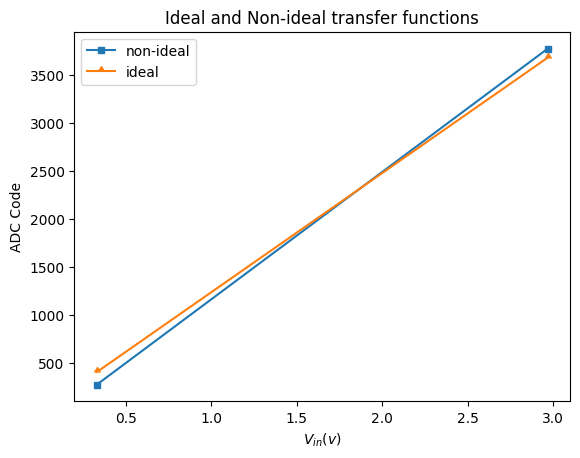

In [10]:
real = [278,3780]
ideal = [409,3686]
vin = [V_low, V_high]
plt.plot(vin,real,"-", label = "non-ideal",marker = "s", markersize = 5)
plt.plot(vin,ideal,"-", label = "ideal", marker = 10, markersize = 5)
plt.xlabel ("$V_{in}(v)$")
plt.ylabel ("ADC Code")
plt.title("Ideal and Non-ideal transfer functions")
plt.legend();

### Collecting Data for Linear Regression

In [11]:
input_voltages = np.array([0.00,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.1,3.2,3.3])
ADC_codes = np.array([0,0,0,111,235,358,488,612,731,853,994,1113,1374,1636,1877,2134,2384,2642,2892,3173,3465,3886,4069,4095,4095])

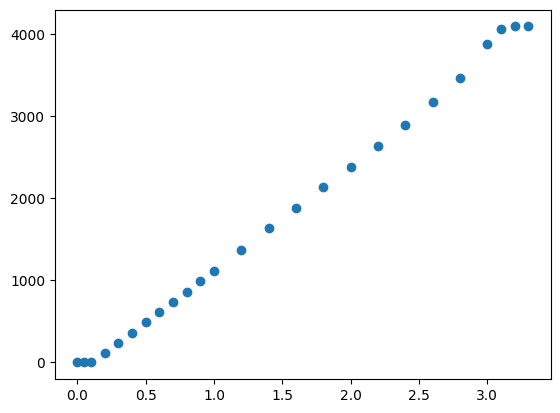

In [12]:
plt.scatter(input_voltages,ADC_codes);

### Callecting Data for Kalman Filter

In [13]:
input_Volatage = 2.0 #
true_ADC_Code = 2482
measured_codes = np.array([2392,2393,2383,2386,2387,2383,2367,2384,2384,2383,2394,2282,2395,2395,2387,2384,2393,2389,2390,2378,2382,2384,2385
])
len(measured_codes)

23

In [14]:
calibrate(np.sum(measured_codes)/len(measured_codes))

2377

In [15]:
def kalman_filter(initial_guess,guess_variance, measurements,measurement_variances, process_noise=0.0, plot = False, true_value = None,precision = 0.1):
    #initial estimations
    state_etimation = initial_guess;
    estimation_variance = guess_variance;
    N = len(measurement_variances)
    #prediction
    predicted_estimation = state_etimation;
    predicted_estimation_variance = guess_variance+process_noise;

    estimates = np.zeros(N+1)
    estimates[0] = state_etimation;
    Kalman_gains = np.zeros(N)
    if plot:
        plt.scatter(0,state_etimation,color = 'red',label = "initial_state");
    
    #iterating in for all given measurements
    for i in range(N):
        #Calculate the Kalman Gian
        Kalman_Gian = predicted_estimation_variance/(predicted_estimation_variance+measurement_variances[i])
        Kalman_gains[i] = Kalman_Gian
        #Compute the current State Estimate
        state_etimation = predicted_estimation + Kalman_Gian*(measurements[i]-predicted_estimation)
        estimates[i+1] = state_etimation
        estimation_variance = (1-Kalman_Gian)*predicted_estimation_variance

        #Compute the prediction using dynamic Model
        predicted_estimation = state_etimation;
        predicted_estimation_variance = estimation_variance+process_noise;
    if plot:
        iterations = np.arange(0,N+1)
        plt.plot(iterations[1:],estimates[1:],marker='s',markersize=5,label = "estimates")
        plt.plot(iterations[1:],measurements,marker = 10, label = "measurements")
        if true_value is not None:
            t_vals = np.ones(N+1)*true_value
            plt.plot(iterations[1:], t_vals[1:],marker=4,label = "true values")
        plt.xlabel ("Iterations")
        plt.title("Kalman Filter Simulations")
        plt.legend()
        plt.show()
        plt.figure();
        plt.plot(Kalman_gains,marker="o",markersize = 5)
        plt.title("Kalman Gians")
        plt.xlabel("Iterations")
    return estimates
    

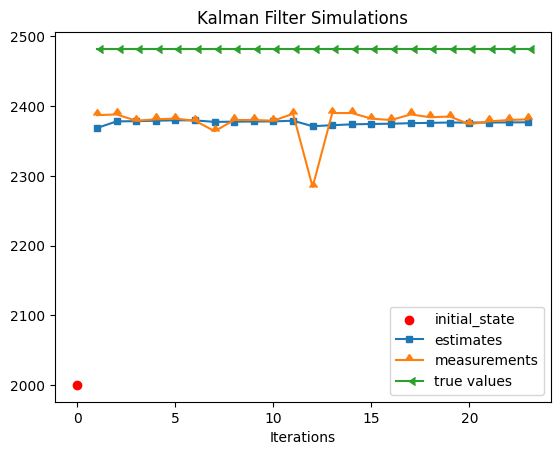

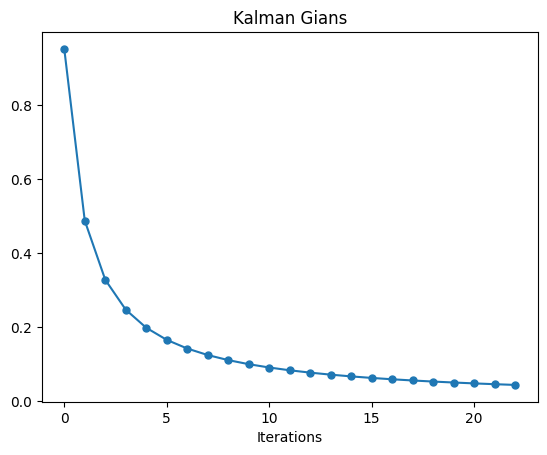

In [19]:
true_ADC_Code = 2482
measured_codes = np.array([2392,2393,2383,2386,2387,2383,2367,2384,2384,2383,2394,2282,2395,2395,2387,2384,2393,2389,2390,2378,2382,2384,2385
])
calibrated = [calibrate(val) for val in measured_codes]
variances = 2*np.ones(len(measured_codes))
initial_estime = 2000
initial_var = 40

estims = kalman_filter(initial_estime,initial_var,calibrated, variances, plot= True, true_value = true_ADC_Code)


In [ ]:
ca